In [112]:
import pandas as pd


In [113]:
df = pd.read_csv('Car_Insurance_Claim.csv')

In [114]:
df = df[~(df['CREDIT_SCORE'].isna() & df['ANNUAL_MILEAGE'].isna())]


In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

def check_variable_vs_target(df, var, target='OUTCOME', title_suffix=''):
    """
    בדיקת הקשר של משתנה ל-target
    כולל:
    1. קורלציית Spearman
    2. boxplot של המשתנה לפי target
    """
    # --- התיקון כאן ---
    # הוספנו nan_policy='omit' כדי להתעלם מערכים חסרים בחישוב
    corr, pval = spearmanr(df[var], df[target], nan_policy='omit')

    print(f"Spearman correlation ({var} vs {target}) {title_suffix}: {corr:.4f}, p-value={pval:.4f}")

    # boxplot
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target, y=var, data=df)
    plt.title(f"{var} vs {target} {title_suffix}")
    plt.tight_layout()
    plt.show()

def compare_distributions_by_target(original_df, filled_df, column, target='OUTCOME'):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # גרף 1: נתונים מקוריים (מתעלם אוטומטית מ-NaN)
    # common_norm=False מאפשר לראות את הצורה גם אם קבוצה אחת קטנה מהשנייה
    sns.kdeplot(data=original_df, x=column, hue=target, fill=True, common_norm=False, alpha=0.3, ax=axes[0])
    axes[0].set_title(f'Original Data: {column} by {target}')

    # גרף 2: נתונים מלאים (אחרי KNN)
    sns.kdeplot(data=filled_df, x=column, hue=target, fill=True, common_norm=False, alpha=0.3, ax=axes[1])
    axes[1].set_title(f'Imputed Data (K=2): {column} by {target}')

    plt.tight_layout()
    plt.show()


Spearman correlation (CREDIT_SCORE vs OUTCOME) (Before Imputation): -0.3274, p-value=0.0000


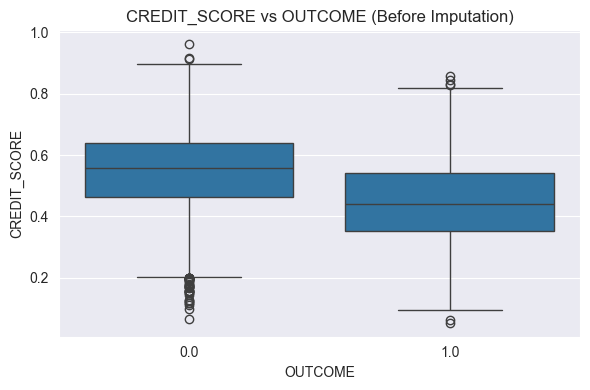

Spearman correlation (ANNUAL_MILEAGE vs OUTCOME) (Before Imputation): 0.1830, p-value=0.0000


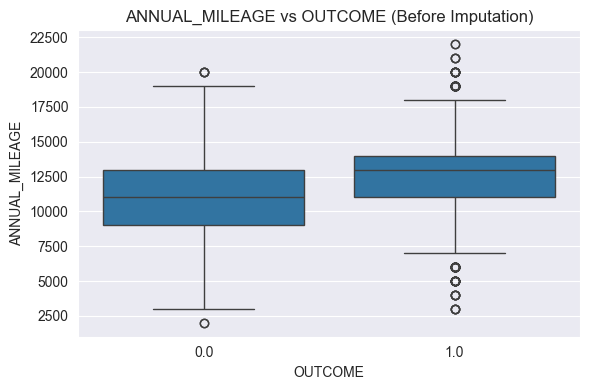

In [116]:

# --- לפני מילוי ---
check_variable_vs_target(df, 'CREDIT_SCORE', title_suffix='(Before Imputation)')
check_variable_vs_target(df, 'ANNUAL_MILEAGE', title_suffix='(Before Imputation)')

In [117]:
#תמלאו פה את הקוד שלכם להשלמת credit score


df['CREDIT_SCORE'] = df['CREDIT_SCORE'].fillna(df['CREDIT_SCORE'].median())


























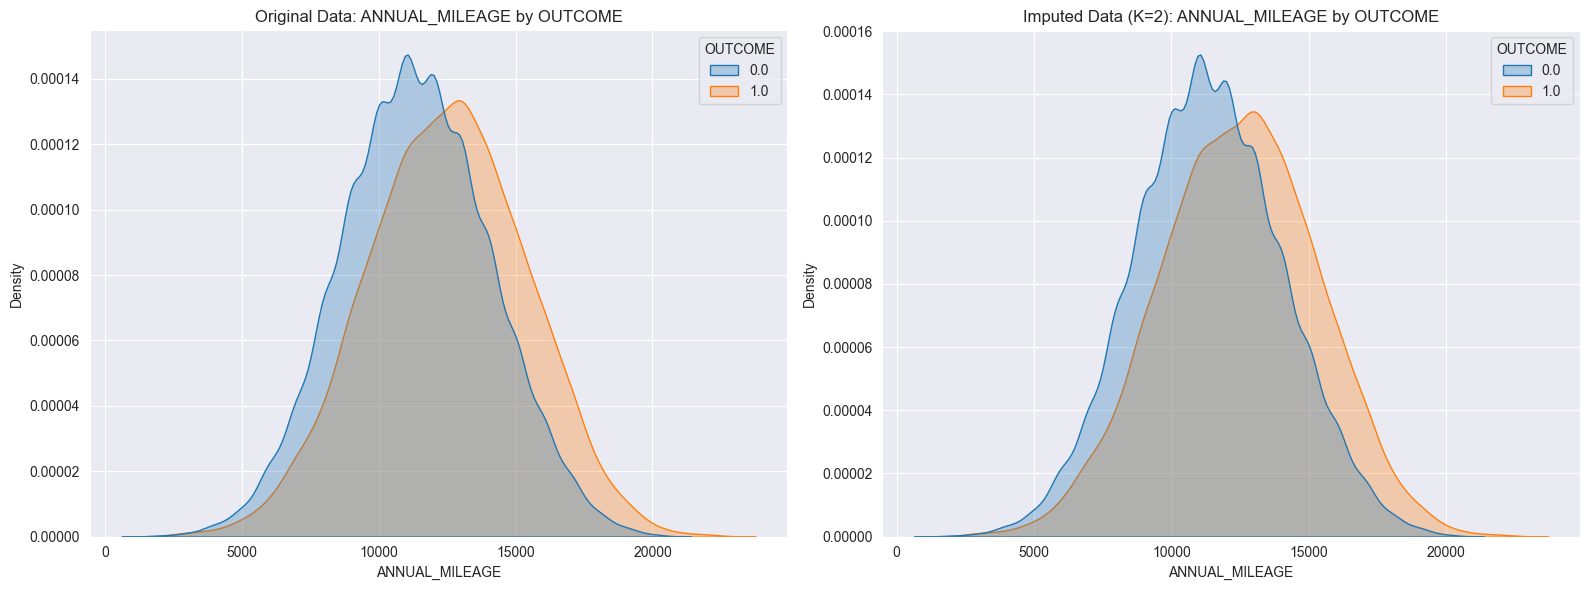

In [118]:
import pandas as pd
from sklearn.impute import KNNImputer # השינוי העיקרי: ייבוא KNN

# 1. הגדרת העמודות
# א. עמודות מספריות ואורדינליות (שיעברו מיפוי)
ordinal_and_numeric_cols = [
    'AGE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
    'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'ANNUAL_MILEAGE', 'CREDIT_SCORE'
]
# ב. עמודות נומינליות (שיעברו One-Hot Encoding)
nominal_cols = ['RACE', 'VEHICLE_TYPE', 'POSTAL_CODE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN']

# 2. יצירת עותק לעבודה שכולל את *כל* העמודות הרלוונטיות
cols_to_use = ordinal_and_numeric_cols + nominal_cols
df_impute = df[cols_to_use].copy()

# 3. המרות למספרים (עבור האורדינליים)
age_mapping = {'16-25': 0, '26-39': 1, '40-64': 2, '65+': 3}
df_impute['AGE'] = df_impute['AGE'].map(age_mapping)

exp_mapping = {'0-9y': 0, '10-19y': 1, '20-29y': 2, '30y+': 3}
df_impute['DRIVING_EXPERIENCE'] = df_impute['DRIVING_EXPERIENCE'].map(exp_mapping)

edu_mapping = {'none': 0, 'high school': 1, 'university': 2}
df_impute['EDUCATION'] = df_impute['EDUCATION'].map(edu_mapping)

income_mapping = {'poverty': 0, 'working class': 1, 'middle class': 2, 'upper class': 3}
df_impute['INCOME'] = df_impute['INCOME'].map(income_mapping)

# --- תוספת: One-Hot Encoding ---
# הופך את העמודות הנומינליות למספרים (0/1) בתוך עותק העבודה
# זה קריטי ל-KNN כי הוא מחשב מרחקים מתמטיים
df_impute = pd.get_dummies(df_impute, columns=nominal_cols, drop_first=True)

# 4. ביצוע האימפיוטציה עם KNN
# n_neighbors=5: משתמש ב-5 הנהגים הכי דומים כדי לחשב ממוצע
imputer = KNNImputer(n_neighbors=2)
df_impute_filled_array = imputer.fit_transform(df_impute)

# 5. המרה חזרה ל-DataFrame זמני כדי לשלוף את הנתון
# משתמשים ב-df_impute.columns כי מספר העמודות גדל בגלל ה-get_dummies
df_impute_filled = pd.DataFrame(
    df_impute_filled_array,
    columns=df_impute.columns,
    index=df.index
)

df_impute_filled['OUTCOME'] = df['OUTCOME']
compare_distributions_by_target(df, df_impute_filled, 'ANNUAL_MILEAGE')

# 6. העתקת הנתונים החסרים לטבלה המקורית
df['ANNUAL_MILEAGE'] = df_impute_filled['ANNUAL_MILEAGE']
# עיגול לאלפים
df['ANNUAL_MILEAGE'] = df['ANNUAL_MILEAGE'].round(-3)

Spearman correlation (CREDIT_SCORE vs OUTCOME) (After Imputation): -0.3119, p-value=0.0000


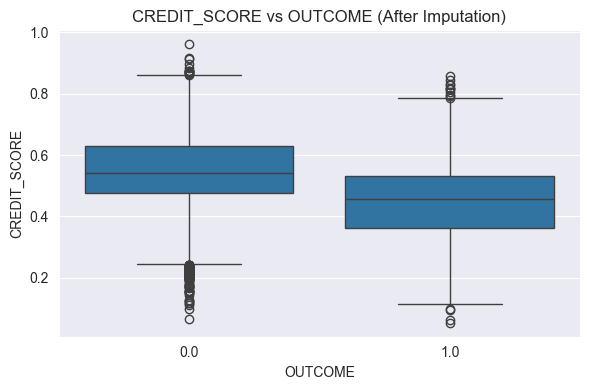

Spearman correlation (ANNUAL_MILEAGE vs OUTCOME) (After Imputation): 0.1831, p-value=0.0000


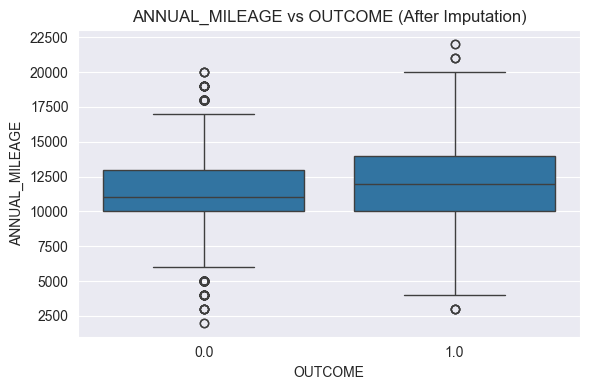

In [119]:

# --- אחרי מילוי ---
# כאן מניחים שמילאת את CREDIT_SCORE ו-ANNUAL_MILEAGE כבר
check_variable_vs_target(df, 'CREDIT_SCORE', title_suffix='(After Imputation)')
check_variable_vs_target(df, 'ANNUAL_MILEAGE', title_suffix='(After Imputation)')


In [120]:
from sklearn.model_selection import train_test_split

# 1. הפרדה בין הפיצ'רים (X) למטרה (y)
# אנחנו מסירים את עמודת המטרה מ-X כדי שהמודל לא "ירמה" ויקבל את התשובה
X = df.drop('OUTCOME', axis=1)
y = df['OUTCOME']


# 2. ביצוע החלוקה (80% אימון, 20% טסט)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# 3. בדיקה שהגדלים הגיוניים (Sanity Check)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test:  {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test:  {y_test.shape}")

Shape of X_train: (7929, 18)
Shape of X_test:  (1983, 18)
Shape of y_train: (7929,)
Shape of y_test:  (1983,)
